In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import cuml
import cupy as cp

from cuml.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [7]:
df = pd.read_csv('creditcard.csv')

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

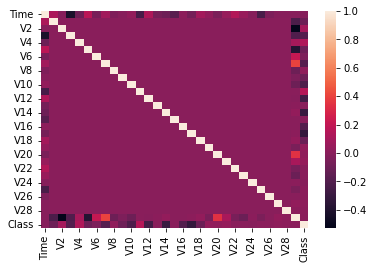

In [9]:
sns.heatmap(df.corr())

<AxesSubplot:xlabel='Time', ylabel='Count'>

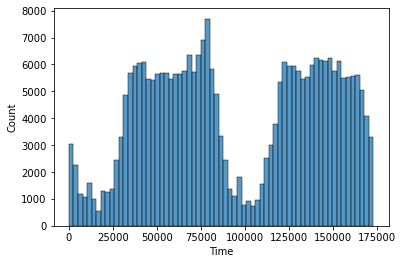

In [10]:
sns.histplot(df['Time'])

In [16]:
data_features = df.iloc[:, 1:-1]
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

tsne = TSNE(n_components = 2)
tsne_transformed = tsne.fit_transform(scaled_data)

/home/yaroslav/.conda/envs/rapids-22.06/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [22:28:55.166025] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/yaroslav/.conda/envs/rapids-22.06/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


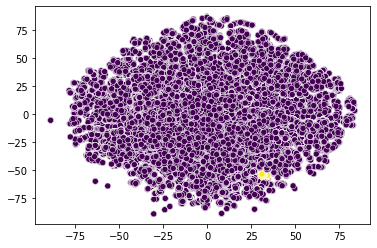

In [43]:
sns.scatterplot(tsne_transformed[:, 0], 
            tsne_transformed[:, 1], c=df['Class'], palette='deep', legend='auto');

# Outlier std

In [12]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [13]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [14]:
data_features = df.iloc[:, :-1]
data_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [15]:
comparison_table, std_outliers = get_column_outliers(data_features, threshold=10)
anomalies_report(std_outliers)

Total number of outliers: 2104
Percentage of outliers:   0.74%


In [16]:
pd.merge(df, std_outliers.astype(int), left_index=True, right_index=True).head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_outlier
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [17]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [18]:
for i in range(1, 29):
    comparison_table, std_outliers = get_column_outliers(data_features, threshold=i)
    print(classification_report(df['Class'],std_outliers.astype(int)))
    print(i, "==="*20)

# Конечно же, нас будет интересовать precision. 
# Мы хотим понять, как много мошеннических сделок мы "окрашиваем" безопасными.
# Наибольший precision наблюдается, если мы считаем, что сделка считается мошеннической при 22 аномальных значениях

              precision    recall  f1-score   support

           0       1.00      0.01      0.01    284315
           1       0.00      1.00      0.00       492

    accuracy                           0.01    284807
   macro avg       0.50      0.50      0.01    284807
weighted avg       1.00      0.01      0.01    284807

1 ============================================================
              precision    recall  f1-score   support

           0       1.00      0.51      0.68    284315
           1       0.00      0.97      0.01       492

    accuracy                           0.51    284807
   macro avg       0.50      0.74      0.34    284807
weighted avg       1.00      0.51      0.68    284807

2 ============================================================
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    284315
           1       0.01      0.90      0.02       492

    accuracy                           0.87    284807
  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.21      0.11      0.15       492

    accuracy                           1.00    284807
   macro avg       0.61      0.56      0.57    284807
weighted avg       1.00      1.00      1.00    284807

22 ============================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.21      0.10      0.13       492

    accuracy                           1.00    284807
   macro avg       0.60      0.55      0.57    284807
weighted avg       1.00      1.00      1.00    284807

23 ============================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.20      0.08      0.11       492

    accuracy                           1.00    284807


# Distance Outliers

In [19]:
class DistanceOutliers(BaseEstimator):
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [20]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=99)
euclidian_model.fit(df)
euclidian_outliers = euclidian_model.predict(df)
anomalies_report(euclidian_outliers)

Total number of outliers: 2849
Percentage of outliers:   1.00%


In [21]:
print(classification_report(df['Class'],euclidian_outliers.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.00      0.00      0.00       492

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      0.99      0.99    284807



# CUDA Support

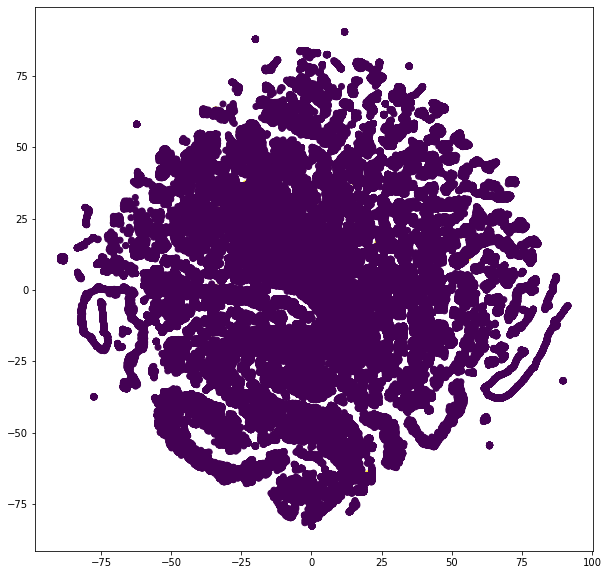

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

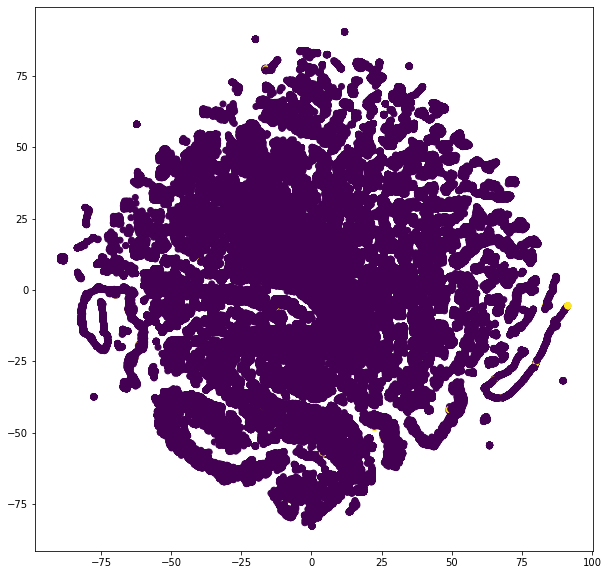

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=std_outliers);

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

In [6]:
%%time

outlier_percentage = 0.05

num_clusters = []
anomaly_percentage = []

eps = 6
eps_history = [eps]

#with tqdm(total=100) as pbar:
while outlier_percentage > 0.002:    
    model = cuml.DBSCAN(eps=eps, max_mbytes_per_batch=5120).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])

    # запишем предыдущий prev_outlier_perc, для обновления pbar
    prev_outlier_perc = outlier_percentage 
    outlier_percentage = sum(labels==1) / len(labels)
    eps += 0.25
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    print(outlier_percentage)

#     if prev_outlier_perc > outlier_percentage:
#         # обновим pbar на разницу outlier_perc'ов
#         pbar.update(round((prev_outlier_perc - outlier_percentage), 2)*100)

0.011200567401784366
0.009890908580196414
0.00885863058141127
0.00794924282057674
0.007096033454233919
0.006457004216890737


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /workspace/.conda-bld/work/include/rmm/mr/device/cuda_memory_resource.hpp:70: cudaErrorMemoryAllocation out of memory

In [7]:
print(eps)

7.5


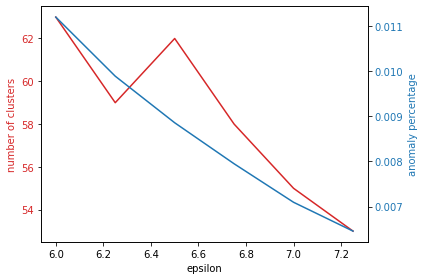

In [8]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [11]:
model = cuml.DBSCAN(eps=7.25, max_mbytes_per_batch=5120)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [14]:
from sklearn.metrics import precision_score

density_outlier = pd.Series(density_outlier)

print(len(density_outlier))
print(classification_report(df['Class'], density_outlier))

284807
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.07      0.26      0.11       492

    accuracy                           0.99    284807
   macro avg       0.53      0.63      0.55    284807
weighted avg       1.00      0.99      0.99    284807

